# California housing price Machine Learning application

Try to predict median house values in Californian districts, given a number of features from these districts.

1. Load `housing` data
1. Explore data
1. Discover and Visualize the Data to Gain Insights
1. [Create training set and a test set](#split)
1. [Write a data preparation pipeline](#pipeline)
1. [Build a model](#build)
1. [Compute performance metrics](#metrics)

In [1]:
%run ../scripts/setup.ipynb

The first three steps are done in the following notebook.

In [2]:
%%capture
%run california_housing_price_data_exploration.ipynb

The goal is to `predict median house values` in Californian districts. The `California Hosuing Prices` dataset is based on data from 1990 California census. Dataset has been already downloaded and put in the `data` folder.

In [3]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  \
0       322.0       126.0         8.3252            452600.0        NEAR BAY   
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY   
2       496.0       177.0         7.2574            352100.0        NEAR BAY   
3       558.0       219.0         5.6431            341300.0        NEAR BAY   
4       565.0       259.0         3.8462            342200.0        NEAR BAY   

  income_cat  rooms_per_household  bedrooms_per_room  population_per_household  
0          5             6.984127           0.146591                  2.555556  
1          5             6.238137           0.155797                  2.109842  
2          5             8.288136           0.129516                  2.802260  
3          4             5.817352           0.184458                  2.547945  
4          3             6.281853           0.172096                  2.181467

## 3. Create a Training and Test Sets <a class='anchor' id='split'></a>

[`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function splits the dataset in training and test sets.
* `random_state` allows you to set the random generator seed and to make this notebook's output identical at every run

In [4]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [5]:
test_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
20046    -119.01     36.06                25.0       1505.0             NaN   
3024     -119.46     35.14                30.0       2943.0             NaN   
15663    -122.44     37.80                52.0       3830.0             NaN   
20484    -118.72     34.28                17.0       3051.0             NaN   
9814     -121.93     36.62                34.0       2351.0             NaN   

       population  households  median_income  median_house_value  \
20046      1392.0       359.0         1.6812             47700.0   
3024       1565.0       584.0         2.5313             45800.0   
15663      1310.0       963.0         3.4801            500001.0   
20484      1705.0       495.0         5.7376            218600.0   
9814       1063.0       428.0         3.7250            278000.0   

      ocean_proximity income_cat  rooms_per_household  bedrooms_per_room  \
20046          INLAND          2             4.192201                NaN   
3024           INLAND          2             5.039384                NaN   
15663        NEAR BAY          3             3.977155                NaN   
20484       <1H OCEAN          4             6.163636                NaN   
9814       NEAR OCEAN          3             5.492991                NaN   

       population_per_household  
20046                  3.877437  
3024                   2.679795  
15663                  1.360332  
20484                  3.444444  
9814                   2.483645

To ensure that the set is representative of the various categories of incomes, it is useful to create `income_cat` attribute according to the `median_income` values: they are mainly clustered around 1.5 to 6, and some of them are beyond 6.

<AxesSubplot:>

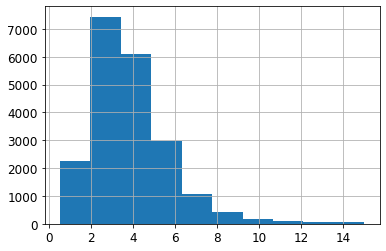

In [6]:
housing["median_income"].hist()

<AxesSubplot:>

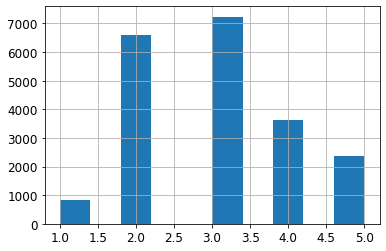

In [7]:
housing["income_cat"].hist()

Let's try [`StratifiedShuffleSplit()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) function based on the `income_cat`.
* this algorithm provides train and test indices to split data in train and test sets.

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Look at the `income_cat` proportions in the test set.

In [9]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

You can measure the `income_cat` in the full dataset.

In [10]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

Let's compare the `income_cat` proportions:
* in the `overall` dataset
* in the test set generated with the `stratified` sampling
* in a test set generated using `random` sampling

In [11]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [12]:
compare_props

Overall  Stratified    Random  Rand. %error  Strat. %error
1  0.039826    0.039971  0.040213      0.973236       0.364964
2  0.318847    0.318798  0.324370      1.732260      -0.015195
3  0.350581    0.350533  0.358527      2.266446      -0.013820
4  0.176308    0.176357  0.167393     -5.056334       0.027480
5  0.114438    0.114341  0.109496     -4.318374      -0.084674

The test set generated using `stratisfied` sampling has `income category` proportions almost identical to those in the `full` dataset.

Remove the `income_cat`.

In [13]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

Copy the `strat_train_set` data frame.

In [14]:
housing = strat_train_set.copy()

In [15]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [16]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  16512.000000  16512.000000        16512.000000  16512.000000   
mean    -119.575635     35.639314           28.653404   2622.539789   
std        2.001828      2.137963           12.574819   2138.417080   
min     -124.350000     32.540000            1.000000      6.000000   
25%     -121.800000     33.940000           18.000000   1443.000000   
50%     -118.510000     34.260000           29.000000   2119.000000   
75%     -118.010000     37.720000           37.000000   3141.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    16354.000000  16512.000000  16512.000000   16512.000000   
mean       534.914639   1419.687379    497.011810       3.875884   
std        412.665649   1115.663036    375.696156       1.904931   
min          2.000000      3.000000      2.000000       0.499900   
25%        295.000000    784.000000    279.000000       2.566950   
50%        433.000000   1164.000000    408.000000       3.541550   
75%        644.000000   1719.000000    602.000000       4.745325   
max       6210.000000  35682.000000   5358.000000      15.000100   

       median_house_value  rooms_per_household  bedrooms_per_room  \
count        16512.000000         16512.000000       16354.000000   
mean        207005.322372             5.440406           0.212873   
std         115701.297250             2.611696           0.057378   
min          14999.000000             1.130435           0.100000   
25%         119800.000000             4.442168           0.175304   
50%         179500.000000             5.232342           0.203027   
75%         263900.000000             6.056361           0.239816   
max         500001.000000           141.909091           1.000000   

       population_per_household  
count              16512.000000  
mean                   3.096469  
std                   11.584825  
min                    0.692308  
25%                    2.431352  
50%                    2.817661  
75%                    3.281420  
max                 1243.333333

## Prepare the Data for Machine Learning Algorithms <a class='anchor' id='pipeline'></a>

* Restart from a clean dataset by using the `strat_train_set` data frame.

Handle missing values, categorical attributes

* Separate the predictors (i.e `median_house_value`) by the labels 

In [17]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning

#### Missing values

ML algorithms do not work with missing values. The critical variable is `total_bedrooms`. It is possible to solve this problem in various ways:

1. removing `na` values `housing.dropna(subset=["total_bedrooms"])`
2. removing the variable `housing.drop("total_bedrooms", axis=1)`
3. replacing `na` with median values

````
median = housing["total_bedrooms"].median() 
housing["total_bedrooms"].fillna(median, inplace=True)
````

In the third case you need to save the `median value` to put in the test set when you evaluate the model.

Create a copy of the housing dataset, `keeping only the rows that contain at least one null`. The `NaN` values are in the `total_bedrooms` attribute.

In [18]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
1606     -122.08     37.88                26.0       2947.0             NaN   
10915    -117.87     33.73                45.0       2264.0             NaN   
19150    -122.70     38.35                14.0       2313.0             NaN   
4186     -118.23     34.13                48.0       1308.0             NaN   
16885    -122.40     37.58                26.0       3281.0             NaN   

       population  households  median_income ocean_proximity  \
1606        825.0       626.0         2.9330        NEAR BAY   
10915      1970.0       499.0         3.4193       <1H OCEAN   
19150       954.0       397.0         3.7813       <1H OCEAN   
4186        835.0       294.0         4.2891       <1H OCEAN   
16885      1145.0       480.0         6.3580      NEAR OCEAN   

       rooms_per_household  bedrooms_per_room  population_per_household  
1606              4.707668                NaN                  1.317891  
10915             4.537074                NaN                  3.947896  
19150             5.826196                NaN                  2.403023  
4186              4.448980                NaN                  2.840136  
16885             6.835417                NaN                  2.385417

In [19]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"]) # option 1 removing `na` values `housing.dropna(subset=["total_bedrooms"])`

Empty DataFrame
Columns: [longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, ocean_proximity, rooms_per_household, bedrooms_per_room, population_per_household]
Index: []

In [20]:
sample_incomplete_rows.drop("total_bedrooms", axis=1) # option 2 removing the variable `housing.drop("total_bedrooms", axis=1)`

longitude  latitude  housing_median_age  total_rooms  population  \
1606     -122.08     37.88                26.0       2947.0       825.0   
10915    -117.87     33.73                45.0       2264.0      1970.0   
19150    -122.70     38.35                14.0       2313.0       954.0   
4186     -118.23     34.13                48.0       1308.0       835.0   
16885    -122.40     37.58                26.0       3281.0      1145.0   

       households  median_income ocean_proximity  rooms_per_household  \
1606        626.0         2.9330        NEAR BAY             4.707668   
10915       499.0         3.4193       <1H OCEAN             4.537074   
19150       397.0         3.7813       <1H OCEAN             5.826196   
4186        294.0         4.2891       <1H OCEAN             4.448980   
16885       480.0         6.3580      NEAR OCEAN             6.835417   

       bedrooms_per_room  population_per_household  
1606                 NaN                  1.317891  
10915                NaN                  3.947896  
19150                NaN                  2.403023  
4186                 NaN                  2.840136  
16885                NaN                  2.385417

For the option 3 , you need to compute the `medial values` on the training set and use it to fill the missing values in the training set.


**NOTE**: You have to save the median value in order to replace missing values in the test set when you need to evaluate the system and when you add new data.

In [21]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3 replacing `na` with median values

In [22]:
sample_incomplete_rows

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
1606     -122.08     37.88                26.0       2947.0           433.0   
10915    -117.87     33.73                45.0       2264.0           433.0   
19150    -122.70     38.35                14.0       2313.0           433.0   
4186     -118.23     34.13                48.0       1308.0           433.0   
16885    -122.40     37.58                26.0       3281.0           433.0   

       population  households  median_income ocean_proximity  \
1606        825.0       626.0         2.9330        NEAR BAY   
10915      1970.0       499.0         3.4193       <1H OCEAN   
19150       954.0       397.0         3.7813       <1H OCEAN   
4186        835.0       294.0         4.2891       <1H OCEAN   
16885      1145.0       480.0         6.3580      NEAR OCEAN   

       rooms_per_household  bedrooms_per_room  population_per_household  
1606              4.707668                NaN                  1.317891  
10915             4.537074                NaN                  3.947896  
19150             5.826196                NaN                  2.403023  
4186              4.448980                NaN                  2.840136  
16885             6.835417                NaN                  2.385417

Use [`SimpleImputer()`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) function to replace `na` values with the `median` values. The `strategy` parameter allows you to specify the imputation strategy.

In [23]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Remove the `text attribute`, because `median` can only be calculated on numerical attributes. So create a copy of the data without text attribute, so remove `ocean_proximity`.

In [24]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [25]:
housing_num.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.70     34.28                27.0       3536.0           646.0   

       population  households  median_income  rooms_per_household  \
12655      2237.0       706.0         2.1736             5.485836   
15502      2015.0       768.0         6.3373             6.927083   
2908        667.0       300.0         2.8750             5.393333   
14053       898.0       483.0         2.2264             3.886128   
20496      1837.0       580.0         4.4964             6.096552   

       bedrooms_per_room  population_per_household  
12655           0.205784                  3.168555  
15502           0.160714                  2.623698  
2908            0.191595                  2.223333  
14053           0.276505                  1.859213  
20496           0.182692                  3.167241

You can `fit` the `imputer` instance to the training data with the `fit()` function. `imputer` computes the median to the numerical attributes and stores results in `statistics_` variable.

In [26]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [27]:
housing_num.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.70     34.28                27.0       3536.0           646.0   

       population  households  median_income  rooms_per_household  \
12655      2237.0       706.0         2.1736             5.485836   
15502      2015.0       768.0         6.3373             6.927083   
2908        667.0       300.0         2.8750             5.393333   
14053       898.0       483.0         2.2264             3.886128   
20496      1837.0       580.0         4.4964             6.096552   

       bedrooms_per_room  population_per_household  
12655           0.205784                  3.168555  
15502           0.160714                  2.623698  
2908            0.191595                  2.223333  
14053           0.276505                  1.859213  
20496           0.182692                  3.167241

Only `total_bedrooms` had missing values. You might have missing values in new data.

In [28]:
imputer.statistics_

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.11900000e+03,
        4.33000000e+02,  1.16400000e+03,  4.08000000e+02,  3.54155000e+00,
        5.23234164e+00,  2.03027043e-01,  2.81766108e+00])

Check that this is the same as manually computing the median of each attribute:

In [29]:
housing_num.median().values

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.11900000e+03,
        4.33000000e+02,  1.16400000e+03,  4.08000000e+02,  3.54155000e+00,
        5.23234164e+00,  2.03027043e-01,  2.81766108e+00])

At this point you can `define` the training set by replacing the missing values with the median values of the learned medians.

In [30]:
X = imputer.transform(housing_num)

X is a numpy array containing the transformed features. You get the same results by applyting the `fit_transform()` function.

In [31]:
print(X)

[[-121.46         38.52         29.         ...    5.48583569
     0.20578363    3.16855524]
 [-117.23         33.09          7.         ...    6.92708333
     0.16071429    2.62369792]
 [-119.04         35.37         44.         ...    5.39333333
     0.19159456    2.22333333]
 ...
 [-122.72         38.44         48.         ...    4.11046512
     0.23479491    2.6627907 ]
 [-122.7          38.31         14.         ...    6.29740519
     0.18383518    2.41117764]
 [-122.14         39.97         27.         ...    5.47715736
     0.20574606    3.17258883]]


In [32]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [33]:
housing_tr.loc[sample_incomplete_rows.index.values]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
1606     -122.08     37.88                26.0       2947.0           433.0   
10915    -117.87     33.73                45.0       2264.0           433.0   
19150    -122.70     38.35                14.0       2313.0           433.0   
4186     -118.23     34.13                48.0       1308.0           433.0   
16885    -122.40     37.58                26.0       3281.0           433.0   

       population  households  median_income  rooms_per_household  \
1606        825.0       626.0         2.9330             4.707668   
10915      1970.0       499.0         3.4193             4.537074   
19150       954.0       397.0         3.7813             5.826196   
4186        835.0       294.0         4.2891             4.448980   
16885      1145.0       480.0         6.3580             6.835417   

       bedrooms_per_room  population_per_household  
1606            0.203027                  1.317891  
10915           0.203027                  3.947896  
19150           0.203027                  2.403023  
4186            0.203027                  2.840136  
16885           0.203027                  2.385417

In [34]:
imputer.strategy

'median'

In [35]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [36]:
housing_tr.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.70     34.28                27.0       3536.0           646.0   

       population  households  median_income  rooms_per_household  \
12655      2237.0       706.0         2.1736             5.485836   
15502      2015.0       768.0         6.3373             6.927083   
2908        667.0       300.0         2.8750             5.393333   
14053       898.0       483.0         2.2264             3.886128   
20496      1837.0       580.0         4.4964             6.096552   

       bedrooms_per_room  population_per_household  
12655           0.205784                  3.168555  
15502           0.160714                  2.623698  
2908            0.191595                  2.223333  
14053           0.276505                  1.859213  
20496           0.182692                  3.167241

#### Handling Text and Categorical Attributes

Now let's preprocess the categorical input feature, `ocean_proximity`.

In [37]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

ocean_proximity
12655          INLAND
15502      NEAR OCEAN
2908           INLAND
14053      NEAR OCEAN
20496       <1H OCEAN
1481         NEAR BAY
18125       <1H OCEAN
5830        <1H OCEAN
17989       <1H OCEAN
4861        <1H OCEAN

Convert these categories from text to numbers. Try [`OrdinalEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) function that encodes categorical features as an integer array.

In [38]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [39]:
np.unique(housing_cat_encoded)

array([0., 1., 2., 3., 4.])

The `ordinal_encoder` stores the list of categories in its `categories_` variable. It is a list of 1D array of categories for each categorical attribute: (in this case we have just 1 categorical attribute).

In [40]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

By using the `OrdinalEncoder` approach ML techniques will assume that two nearby values are more similar than two distant values. This is not the case for this example, where categories `0=<1H OCEAN` and `4=NEAR OCEAN` are similar than `0=<1H OCEAN` and `1=INLAND`. 

Try [`OneHotEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) function that encodes categorical features as a one-hot numeric array. It allows you to create a binary attribute per category. For example:
* one attribute is equal to 1 when category is `<1H OCEAN`, 0 otherwise;
* one attribute is equal to 1 when category is `1=INLAND`, 0 otherwise;
* and so on
This approach is called `one-hot encoding` because only one attribute will be equal to 1, while the others will be 0.

In [41]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` returns a sparse matrix. Each row is full of 0s except for a single 1 per row. This can consume tons of memory, you can only store the location of hte nonzero elements. You can convert the sparse matrix to a dense array, if needed, by calling the `toarray()` function. 

In [42]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [43]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

You can list the encoder's `categories_` variable.

In [44]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

#### Custom Transformers

Let's create a `custom transformer` to perform clean operations or combine specific attributes or add extra attributes. Use [`BaseEstimator`](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html) to get and set new hyperparameter, and [`TransformerMixin`](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) to perform a fit trasformer operation. 

Create a `CombinedAttributesAdder` class, that is a new type of object that allows new instances of that type to be made:
* Each class instance can have attributes attached to it for maintaining its state. 
* Class instances can also have methods (defined by its class) for modifying its state.

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
col_names = ["total_rooms", "total_bedrooms", "population", "households"]
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices
print(rooms_ix, bedrooms_ix, population_ix, households_ix)

# Here it is a defined a class object
class CombinedAttributesAdder(BaseEstimator, TransformerMixin): 
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

3 4 5 6


This class allows you to add a new hyperparameter `add_bedrooms_per_room`.

In [46]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs

array([[-121.46, 38.52, 29.0, ..., 3.168555240793201, 5.485835694050992,
        3.168555240793201],
       [-117.23, 33.09, 7.0, ..., 2.6236979166666665, 6.927083333333333,
        2.6236979166666665],
       [-119.04, 35.37, 44.0, ..., 2.223333333333333, 5.3933333333333335,
        2.223333333333333],
       ...,
       [-122.72, 38.44, 48.0, ..., 2.6627906976744184,
        4.1104651162790695, 2.6627906976744184],
       [-122.7, 38.31, 14.0, ..., 2.411177644710579, 6.297405189620759,
        2.411177644710579],
       [-122.14, 39.97, 27.0, ..., 3.1725888324873095, 5.477157360406092,
        3.1725888324873095]], dtype=object)

`housing_extra_attribs` is a NumPy array, we've lost the column names. To recover a `DataFrame`, you could run this:

In [47]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

longitude latitude housing_median_age total_rooms total_bedrooms  \
12655   -121.46    38.52               29.0      3873.0          797.0   
15502   -117.23    33.09                7.0      5320.0          855.0   
2908    -119.04    35.37               44.0      1618.0          310.0   
14053   -117.13    32.75               24.0      1877.0          519.0   
20496    -118.7    34.28               27.0      3536.0          646.0   

      population households median_income ocean_proximity rooms_per_household  \
12655     2237.0      706.0        2.1736          INLAND            5.485836   
15502     2015.0      768.0        6.3373      NEAR OCEAN            6.927083   
2908       667.0      300.0         2.875          INLAND            5.393333   
14053      898.0      483.0        2.2264      NEAR OCEAN            3.886128   
20496     1837.0      580.0        4.4964       <1H OCEAN            6.096552   

      bedrooms_per_room population_per_household rooms_per_household  \
12655          0.205784                 3.168555            5.485836   
15502          0.160714                 2.623698            6.927083   
2908           0.191595                 2.223333            5.393333   
14053          0.276505                 1.859213            3.886128   
20496          0.182692                 3.167241            6.096552   

      population_per_household  
12655                 3.168555  
15502                 2.623698  
2908                  2.223333  
14053                 1.859213  
20496                 3.167241

#### Feature Scaling

Some ML techniques do not perform well when the input have different scales:
* total number of rooms `total_rooms` ranges from 6 to 39,320
* `median_income` ranges from 0 to 15

In [48]:
print(housing_extra_attribs.total_rooms.min(), housing_extra_attribs.total_rooms.max())

6.0 39320.0


In [49]:
print(housing_extra_attribs.median_income.min(), housing_extra_attribs.median_income.max())

0.4999 15.0001


Two simple ways to get all attributes with the same scale are:
* `min-max scaling or normalization`: all values are shifted and rescaled so that they end up ranging from 0 to 1. First subtract the min value and then divide by the max minus the min. This approach is supported by [`MinMaxScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) class.
* `standardization`: first it subtracts the mean value and then it divides by the standard deviation. This approach is supported by [`StandardScaler()`](https://www.google.com/search?q=standard+scaler&oq=standard+scaler&aqs=chrome..69i57j0i10i512j0i20i263i512j0i512l7.2497j0j4&sourceid=chrome&ie=UTF-8) class.

You need to apply this procedure to the training data only.

#### Transformation Pipelines

The [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) class helps with the data cleaning steps.

Now let's build a pipeline for preprocessing the numerical attributes:

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

The `Pipeline` class takes a list of `name/estimator` pairs defining a sequence steps. 
* The `names` must be unique and do not contain `__`.
* The `estimators` are `transformers`.
The `num_pipleline` object calls `fit_transform()` sequentially on all transformers, passing the output of each call as the parameter to the next call until it reaches the final estimator.

In [51]:
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

Now let's build a pipeline for preprocessing both the numerical attributes and categorical attributes. Use [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) class that applies transformers to columns of an array or pandas DataFrame.

In [52]:
housing_num

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.70     34.28                27.0       3536.0           646.0   
...          ...       ...                 ...          ...             ...   
15174    -117.07     33.03                14.0       6665.0          1231.0   
12661    -121.42     38.51                15.0       7901.0          1422.0   
19263    -122.72     38.44                48.0        707.0           166.0   
19140    -122.70     38.31                14.0       3155.0           580.0   
19773    -122.14     39.97                27.0       1079.0           222.0   

       population  households  median_income  rooms_per_household  \
12655      2237.0       706.0         2.1736             5.485836   
15502      2015.0       768.0         6.3373             6.927083   
2908        667.0       300.0         2.8750             5.393333   
14053       898.0       483.0         2.2264             3.886128   
20496      1837.0       580.0         4.4964             6.096552   
...           ...         ...            ...                  ...   
15174      2026.0      1001.0         5.0900             6.658342   
12661      4769.0      1418.0         2.8139             5.571932   
19263       458.0       172.0         3.1797             4.110465   
19140      1208.0       501.0         4.1964             6.297405   
19773       625.0       197.0         3.1319             5.477157   

       bedrooms_per_room  population_per_household  
12655           0.205784                  3.168555  
15502           0.160714                  2.623698  
2908            0.191595                  2.223333  
14053           0.276505                  1.859213  
20496           0.182692                  3.167241  
...                  ...                       ...  
15174           0.184696                  2.023976  
12661           0.179977                  3.363188  
19263           0.234795                  2.662791  
19140           0.183835                  2.411178  
19773           0.205746                  3.172589  

[16512 rows x 11 columns]

In [53]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs), #num_attribs transformed with num_pipeline
        ("cat", OneHotEncoder(), cat_attribs), #cat transformed with onehotencoder
    ])

housing_prepared = full_pipeline.fit_transform(housing)

The `ColumnTransformer()` function requires a list of tuples, where each tuple contains a name, a transformer and a list of names (or indices) of columns that the transformer should be applied to.  

The `full_pipeline` object applies a `fit_transform()` to the housing data. 

In [54]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [55]:
type(housing_prepared)

numpy.ndarray

In [56]:
housing_prepared.shape

(16512, 19)

## Select and Train a Model <a class='anchor' id='model'></a>

### Training and Evaluating on the Training Set

Let's first train a Linear Regression model.

In [57]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

Let's try the full preprocessing pipeline on a few training instances: the first 5 rows.

In [58]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Compare predictions against the actual values.')
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels)) 
print(100-100*lin_reg.predict(some_data_prepared)/list(some_labels))

Compare predictions against the actual values.
Predictions: [ 83836.78432038 305631.11438241 150098.65527848 187972.73800539
 241953.08535364]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]
[-16.27848033  -9.31012675 -81.49776938 -67.08687823  -1.53297749]


The predictions are not exactly accurate. 

## Compute performance metrics <a class='anchor' id='metrics'></a>

To measure this regression model performance you can use the [`mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) function that performs a mean squared error regression loss.

In [59]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68147.64600570854

**Note**: you can get the RMSE directly by calling the `mean_squared_error()` function with `squared=False`.

In [60]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions, squared=False)
lin_rmse

68147.64600570854

In [61]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49071.278404386125

This result is not very good, mainly because it shows a prediction error of 68,628 dollar. 

It seems that the model underfit the training data, due to the features that do not provide enough information or the model that is not powerful enough.

To fix underfitting, you can select a powerful model or add more features.

Let's try a `Decition Tree Regressor` model that is capable of finding complex nonlinear relationships in the data.

In [62]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [63]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Here the error is 0. The model maybe has overfit the data. To check this you can follow one of the following solutions:
* use part of the training set for training and part of it for model validation
* use k-fold cross validation feature

### Better Evaluation Using Cross-Validation

The [`cross-validation`](https://scikit-learn.org/stable/modules/cross_validation.html) approach  uses different portions of the data to test and train a model on different iterations. You can use the [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function to randomly splits the training set into `k` distinct subsets called `folds`, then it trains and evaluates a model `k` times, picking a different `fold` for evaluation every time and training on the other `k-1` folds. 

In the following code, `k` is set to 10. The result is an array containing the 10 evaluation scores. 

In [64]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)

In [65]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [72507.06929076 70938.34389572 68969.61701121 72008.3147559
 69576.77700412 76911.00011308 70706.14671618 74136.58143839
 67591.18850635 72407.05029764]
Mean: 71575.20890293615
Standard deviation: 2541.5610453927866


The Decision Tree has a score of approximately 71,407 with +/- 2,439. 

Let's compute the same scores for Linear Regression.

In [66]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71175.20367855 63821.26974903 67697.80546255 68278.06070129
 66715.42204686 72268.49850759 69890.50682343 68450.2338678
 65939.95316432 70071.80569063]
Mean: 68430.87596920486
Standard deviation: 2409.1268457999013


The `Decision Tree` model seems to perform worse than the `Linear Regression` model due to the ovefitting. 

Let's try another model: `RandomForestRegressor`. Random Forest works by training many Decision Trees on random subsets of the features, than averaging out their predictions. It is an `Ensemble learning` model, because it builds a model on top of many other models.

In [67]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [68]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18660.768029715546

In [69]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51443.18973844 48613.62956597 46979.60405849 52152.60920956
 47510.67438746 51732.97817916 52440.81816611 50056.84192287
 48729.15639315 54192.99886588]
Mean: 50385.25004870922
Standard deviation: 2250.204975441205


In [70]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     68430.875969
std       2539.442668
min      63821.269749
25%      66961.017901
50%      68364.147285
75%      70026.480974
max      72268.498508
dtype: float64

Let's try another model: `Support Vector Machine`. 

Below the SVR (Epsilon-Support Vector Regression) model is used with the `kernel=linear` parameter.

In [71]:
from sklearn.svm import SVR

svm_reg = SVR()
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

118580.93700297091

In [72]:
svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

Scores: [116730.81148696 120113.52213814 113927.1294022  120402.49349709
 114689.90224117 122778.84847224 119858.07953505 118283.58715734
 120230.36918731 118841.0562458 ]
Mean: 118585.57993632944
Standard deviation: 2608.0254992999726
